<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DataFrameMakerML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


































#Init

In [1]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Keras libs
import keras
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation
from keras.layers import BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import load_model

import math
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix
import torchvision.models as models
from decimal import Decimal
from mpl_toolkits.axisartist.axislines import AxesZero
import pickle

In [3]:
class MLAnalyzer(object):

  def __str__(self):
    printed = ""
    for l in self.model.layers:
      printed += str(l.name) + ' ' + str(l.input_shape[1]) + ' ==> ' + str(l.output_shape[1]) + '\n'
    return printed

  def __init__(self, varcolumns=None, xTrain=None, yTrain=None, xVal=None, yVal=None, xTest=None, yTest=None, model=None, history=None, scaler=None):
    self.model = model
    self.history = history

    self.xTrain = xTrain
    self.yTrain = yTrain
    self.xVal = xVal
    self.yVal = yVal
    self.xTest = xTest
    self.yTest = yTest
    self.cols = varcolumns #Dictionary of variables and their ranges
    self.scaler = scaler

    self.rejectionList = []
    self.ceList = []
    
    self.predictions = []
    self.avg_predictions = []
    self.cutoff = -1
    self.rounded_predictions = []
    self.eventError = []

    self.conf_matrix = []
    self.fractional_matrix = []
    self.matrix_errors = []
    self.event_errors = []
    self.final_matrix = None

    self.TPInputs = [] #True positive
    self.FPInputs = [] #False positive
    self.FNInputs = [] #False negative
    self.TNInputs = [] #True negative

  def save(self, fname):
    modelpath = main_path + 'saved_models'
    dump = open(modelpath + '/' + fname + '.pkl', 'wb+')

    pickle.dump((self.xTrain, self.yTrain, self.xVal, self.yVal, self.xTest, self.yTest), dump)

    self.model.save(modelpath + '/' + fname + '.h5')

  def load(self, fname):
    modelpath = main_path + 'root_files_cry4/saved_models'
    sifter = open(modelpath + '/' + fname + '.pkl', 'rb')
    self.xTrain, self.yTrain, self.xVal, self.yVal, self.xTest, self.yTest = pickle.load(sifter)
    self.model = load_model(modelpath + '/' + fname + '.h5')

#Load Scalers and models

In [27]:
fileopener = open(main_path+"root_files_cry4/Saved_Data/scalers.pkl", "rb")
CRVscaler, noCRVscaler = pickle.load(fileopener)

cinnamonBagel = MLAnalyzer()
cinnamonBagel.load('cinnamonBagel')
plainBagel = MLAnalyzer()
plainBagel.load('PlainBagel')

#Define variables list

In [28]:
all_variables_list = {'crvinfo__x': [-8000, 1000], 
                  'crvinfo__y': [0, 3500],
                  'crvinfo__z': [-5000, 20000],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

In [29]:
Z_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500], #only z as the crv variable
                  'deent_om': [-0.01, 0.05],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200],
                  'crvinfo__z': [-5000, 20000]
                  }

In [30]:
dT_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1], #only dT as the crv variable
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

In [31]:
dTZ_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200],
                  'crvinfo__z': [-5000, 20000]
                  }

In [32]:
dTZPE_noMom_variables_list = {
                  'crvinfo__z': [-5000, 20000],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'deent_d0_om' : [300, 1200]
                  }

In [33]:
noCRV_noMom_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'deent_d0_om' : [300, 1200]
                  }

In [34]:
translation = {'crvinfo__x': "x position", 
                  'crvinfo__y': "y position",
                  'crvinfo__z': "z position",
                  'de_nhits': "Downstream tracker hits",
                  'ue_nhits': "Upstream tracker hits",
                  'dequal_TrkPID': "Particle ID", #calorimeter
                  'dequal_TrkQual': "Track Quality",
                  'deent_td': "Pitch Angle", #z axis
                  'deent_z0': "z0 of track",
                  'deent_d0': "distance from z axis",
                  'deent_om': 'Min transverse radius',
                  'crvinfo__PEs': "PE yield",
                  'crvinfo__dT': "Delta-T = T_crv - T_tracker",
                  'deent_mom': "Momentum",
                  'deent_d0_om' : 'Max transverse radius',
                  'is_cosmic':'cosmic status'
                  }

In [35]:
var_list_tosave=['evtinfo__eventid',
 'evtinfo__runid',
 'evtinfo__subrunid',
 'de_status',
 'de_pdg',
 'de_nhits',
 'de_t0',
 'deent_mom',
 'deent_d0',
 'deent_p0',
 'deent_om',
 'deent_z0',
 'deent_td',
 'dequal_TrkPID',
 'dequal_TrkQual',
 'trigbits',
 'ue_status',
 'ue_nhits',
 'crvinfo__crvSectorType',
 'crvinfo__x',
 'crvinfo__y',
 'crvinfo__z',
 'crvinfo__PEs',
 'crvinfo__timeWindowStart',
 'crvinfo__nCoincidenceHits',
 'crvinfomc__x',
 'crvinfomc__y',
 'crvinfomc__z',
 'bestcrv',
 'is_high',
 'crvinfo__dT',
 'deent_d0_om',
 'is_triggered']

In [36]:
variables_list = all_variables_list

#Define cuts

In [37]:
#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)
#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)
# Extended momentum window cut`
cuts = [
    "(deent_mom > 103.85)",
    "(deent_mom < 105.1)"
    # "(deent_mom > 100)",
    # "(deent_mom < 110)"
]
cut_extmom = " & ".join(cuts)
# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]

# crv_time = "((-de_t0 + crvinfo__timeWindowStart) > 50 | (de_t0-crvinfo__timeWindowStart) > 150.0)"
crv_time = "((crvinfo__dT > 50) and (crvinfo__dT < -150))"

#crv_time = "de_t0-crvinfo__timeWindowStart > 350.0"


cut_lbox = " & ".join(cuts)

cut_lbox = " & ".join(cuts)


In [38]:
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom_orig = cut_extmom
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

#Load, analyze and save CRY4 sample

In [24]:
CRY4ANA = False

if CRY4ANA:
  df = pd.read_hdf(main_path + "root_files_cry4/cry4df.h5")
else:
  cry3file = open(main_path+"root_files_cry4/Saved_Data/allData.pkl", "rb")
  df = pickle.load(cry3file)
  df = df.query('is_high>-1')
  df = df[var_list_tosave]

In [25]:
noCRV = df[(df['crvinfo__PEs']<=-2500)] #Data Filtration
onlyCRV = df[(df['crvinfo__PEs']>=-1)] #Data Filtration

In [39]:
noCRV_X_test = noCRVscaler.transform(noCRV[list(noCRV_noMom_variables_list.keys())])
onlyCRV_X_test = CRVscaler.transform(onlyCRV[list(dTZPE_noMom_variables_list.keys())])

In [40]:
noCRV_X_pred = plainBagel.model.predict(noCRV_X_test)
onlyCRV_X_pred = cinnamonBagel.model.predict(onlyCRV_X_test)

In [41]:
pd.options.mode.chained_assignment = None
noCRV['pred'] = noCRV_X_pred.flatten().tolist()
onlyCRV['pred'] = onlyCRV_X_pred.flatten().tolist()

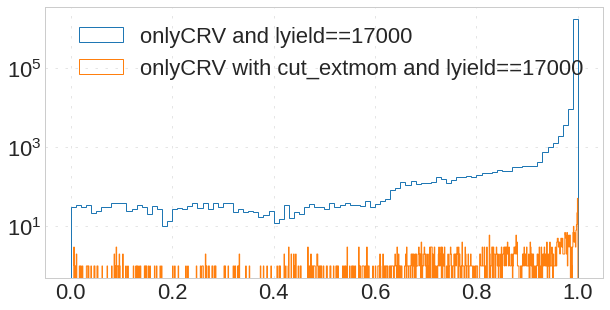

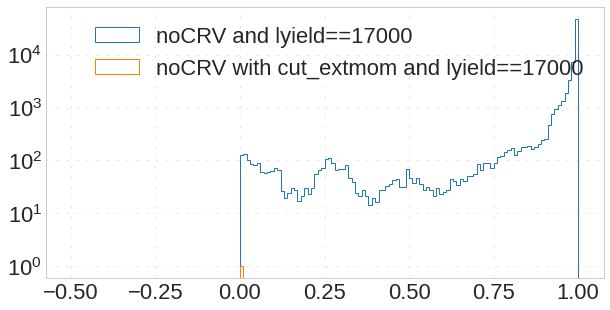

In [42]:
if CRY4ANA:
  plt.hist(onlyCRV.query('lyield==17000')['pred'], bins=100, histtype='step', label='onlyCRV and lyield==17000');
  plt.hist(onlyCRV.query(cut_extmom+'& lyield==17000')['pred'], bins=1000, histtype='step', label='onlyCRV with cut_extmom and lyield==17000');
else:
  plt.hist(onlyCRV['pred'], bins=100, histtype='step', label='onlyCRV and lyield==17000');
  plt.hist(onlyCRV.query(cut_extmom)['pred'], bins=1000, histtype='step', label='onlyCRV with cut_extmom and lyield==17000');

plt.yscale('log')
plt.legend()

plt.figure()
if CRY4ANA:
  plt.hist(noCRV.query('lyield==17000')['pred'], bins=100, histtype='step', label='noCRV and lyield==17000');
  plt.hist(noCRV.query(cut_extmom+'& lyield==17000')['pred'], bins=100, histtype='step', label='noCRV with cut_extmom and lyield==17000');
else:
  plt.hist(noCRV['pred'], bins=100, histtype='step', label='noCRV and lyield==17000');
  plt.hist(noCRV.query(cut_extmom)['pred'], bins=100, histtype='step', label='noCRV with cut_extmom and lyield==17000');
plt.yscale('log')
plt.legend()

In [47]:
df = onlyCRV.append(noCRV)
if CRY4ANA:
  h5file='drive/MyDrive/root_files_cry4/cr4dfml.hd5'
else:
  h5file='drive/MyDrive/root_files_cry4/cr3dfml.hd5'
store = pd.HDFStore(h5file, mode='w')
store['cry3ml'] = df
store.close()